In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from ndbc_api import NdbcApi
from datetime import datetime, timedelta
import requests, tarfile
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import glob
from cartopy.feature import GSHHSFeature
import cartopy.io.shapereader as shpreader
import matplotlib.dates as mdates
from datetime import datetime
import pytz
from datetime import timedelta, timezone
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
from matplotlib.transforms import offset_copy
import matplotlib.patheffects as pe

# Choose your time zone (e.g., US/Eastern, UTC, Pacific/Honolulu, etc.)
# plt.rcParams['font.family'] = 'Helvetica'  # Clean and modern
plt.rcParams['font.family'] = 'DejaVu Sans'  # Has full font weights


In [3]:
# Set up dates and get station data
tz = pytz.timezone('UTC')
today = datetime.now(tz)
today_EST = datetime.now(pytz.timezone('EST'))
dates = {
    'today': today.strftime('%Y-%m-%d'),
    'yesterday': (today - timedelta(days=3)).strftime('%Y-%m-%d'),
    'tomorrow': (today + timedelta(days=3)).strftime('%Y-%m-%d')
}

time_range = pd.date_range(
    start=dates['yesterday'],
    end=dates['tomorrow'],
    freq='D'
)

yday = "".join(dates["yesterday"].split("-"))
tday = "".join(dates["today"].split("-"))

In [4]:
# Get station info
api = NdbcApi()
# station_id = '44090' #Nantucket
# station_id = '46221' #LA
station_id = "bzbm3"; station_name = "Woods Hole, MA"
station_meta = api.station(station_id=station_id)
location = station_meta["Location"].split()
latitude = float(location[0]) * (-1 if location[1] in ['S'] else 1)
longitude = float(location[2]) * (-1 if location[3] in ['W'] else 1)

In [5]:
bathy = xr.open_dataset("gebco_woho.nc").elevation
bathy = np.abs(bathy.where(bathy < 0))

In [6]:
# Get the data
df = api.get_data(
    station_ids=[station_id],
    mode='stdmet',
    start_time=dates['yesterday'],
    end_time=dates['tomorrow']
)[["WTMP"]].astype("float32")

df = df.reset_index()

# Convert 'timestamp' to datetime and set as index
df['time'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.set_index('time')
df = df.sort_index()
df = df[~df.index.isna()]

# Drop original 'timestamp' column (no longer needed)
df = df.drop(columns=['timestamp'])

# Safety check: empty
if df.empty:
    raise ValueError(f"No data returned for station {station_id}")

print("df.head() before filtering")
print(df.head())

print("df.index[:10] before filtering")
print(df.index[:10])

df.index = pd.to_datetime(df.index, errors='coerce')
if df.index.tz is None:
    df.index = df.index.tz_localize('UTC')  # if originally in UTC
df.index = df.index.tz_convert('US/Eastern')
df.index = df.index.tz_localize(None)  # strip tz for plotting or xarray

print("df.head() after filtering")
print(df.head())


# Safety check: no usable numeric data
if df.empty:
    raise ValueError(f"No numeric data to convert for station {station_id}")

# Rename index for xarray and convert
df = df.rename_axis(index="time")

# 1. Make sure the index is datetime
df.index = pd.to_datetime(df.index, errors='coerce')

# 2. If index is naive (no tz), localize to UTC
if df.index.tz is None:
    df.index = df.index.tz_localize("UTC")

# 3. Convert to US/Eastern
df.index = df.index.tz_convert("US/Eastern")
df.index = df.index.tz_localize(None)

stdmet_df = xr.Dataset.from_dataframe(df)

stdmet_df_final = stdmet_df.isel(time=~stdmet_df["WTMP"].isnull().values).isel(time=-1)

df.head() before filtering
                          WTMP
time                          
2025-06-29 00:00:00  19.700001
2025-06-29 00:06:00  19.700001
2025-06-29 00:12:00  19.700001
2025-06-29 00:18:00  19.700001
2025-06-29 00:24:00  19.700001
df.index[:10] before filtering
DatetimeIndex(['2025-06-29 00:00:00', '2025-06-29 00:06:00',
               '2025-06-29 00:12:00', '2025-06-29 00:18:00',
               '2025-06-29 00:24:00', '2025-06-29 00:30:00',
               '2025-06-29 00:36:00', '2025-06-29 00:42:00',
               '2025-06-29 00:48:00', '2025-06-29 00:54:00'],
              dtype='datetime64[ns]', name='time', freq=None)
df.head() after filtering
                          WTMP
time                          
2025-06-28 20:00:00  19.700001
2025-06-28 20:06:00  19.700001
2025-06-28 20:12:00  19.700001
2025-06-28 20:18:00  19.700001
2025-06-28 20:24:00  19.700001


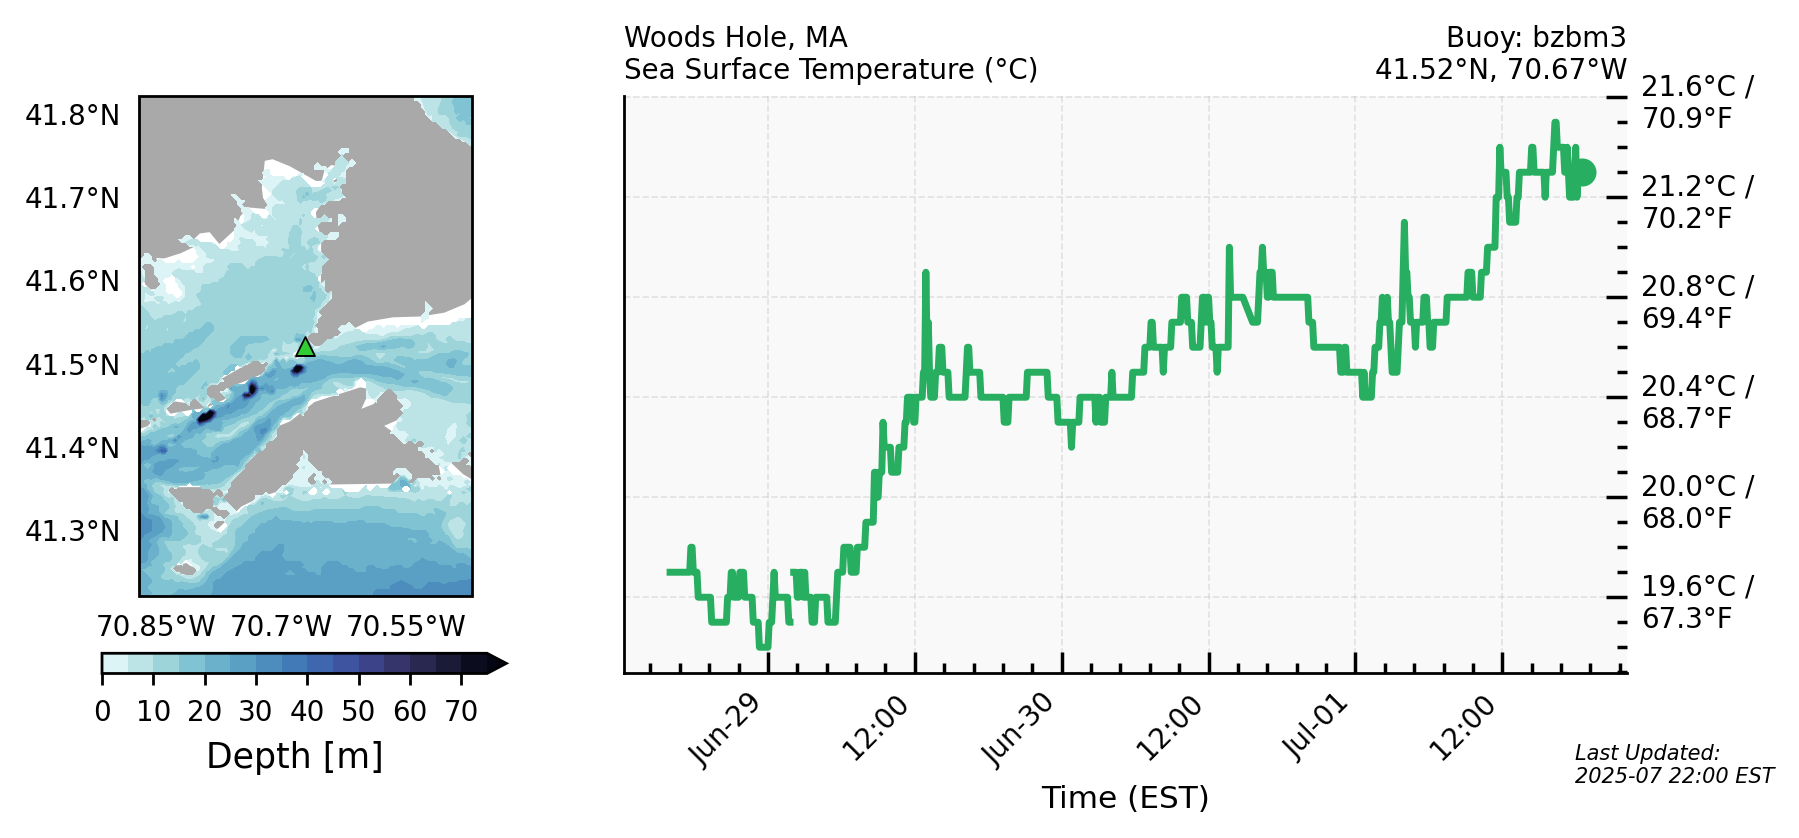

In [12]:
# Global settings
plt.rcParams.update({
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'savefig.transparent': True,
})

# Create figure and GridSpec
fig = plt.figure(figsize=(8, 3), facecolor='white', dpi=250)
gs = gridspec.GridSpec(1, 3, figure=fig, wspace=0.2)

# -------- Bathymetry Map --------
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='darkgrey')
contour = ax1.contourf(
    bathy.lon, bathy.lat, bathy,
    levels=np.arange(0, 80, 5),
    cmap=cmocean.cm.ice_r, extend="max",
    transform=ccrs.PlateCarree()
)
cbar = fig.colorbar(
    contour, ax=ax1, orientation='horizontal',
    pad=0.1, fraction=0.035, label='Depth [m]'
)
cbar.ax.tick_params(labelsize=8)

# Set extent and gridlines
dlon, dlat = 0.2, 0.3
ax1.set_extent([longitude - dlon, longitude + dlon,
                latitude - dlat, latitude + dlat])
gl = ax1.gridlines(
    draw_labels=True,
    color='gray', alpha=0.0
)
gl.top_labels = gl.right_labels = False
gl.xlabel_style = gl.ylabel_style = {'size': 8}

# Buoy marker
ax1.scatter(
    longitude, latitude,
    marker='^', s=30, color='limegreen',
    edgecolor='black', linewidth=0.5,
    transform=ccrs.PlateCarree(), zorder=10
)

# -------- Time Series --------
ax2 = fig.add_subplot(gs[0, 1:])
ax2.set_facecolor("#f9f9f9")
for spine in ['top', 'right']:
    ax2.spines[spine].set_visible(False)

# Titles and labels
ax2.text(
    0, 1.02,
    f"{station_name}\nSea Surface Temperature (°C)",
    transform=ax2.transAxes, ha='left', va='bottom', fontsize=8
)
buoy_location_text = f"Buoy: {station_id}\n{float(location[0]):.2f}°{location[1]}, {float(location[2]):.2f}°{location[3]}"
ax2.text(
    1, 1.02,
    # f"Buoy: {station_id}\n{' '.join(location[:2])}, {' '.join(location[2:4])}",
    buoy_location_text,
    transform=ax2.transAxes, ha='right', va='bottom', fontsize=8,
)

# Plot the data
ax2.plot(
    stdmet_df.time,
    stdmet_df["WTMP"],
    color="#27ae60",
    linewidth=2,
    zorder=2,
    # path_effects=[
    #     pe.Stroke(linewidth=3, foreground="black"),  # black border
    #     pe.Normal()                                  # then normal colored line
    # ]
)
ax2.scatter(
    stdmet_df_final.time, stdmet_df_final["WTMP"].values,
    s=50, 
    # edgecolor='black', 
    color='#27ae60', zorder=5
)

# Time axis formatting
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator())
)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Axis labels and grid
ax2.set_xlabel('Time (EST)', fontsize=9)
ax2.grid(linestyle='--', linewidth=0.5, alpha=0.3, zorder=0)
ax2.xaxis.get_offset_text().set_visible(False)

# Y-axis on right with custom formatter
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

def celsius_fahrenheit_formatter(x, pos):
    f = x * 9/5 + 32
    return f"{x:.1f}°C /\n{f:.1f}°F"

ax2.yaxis.set_major_formatter(
    ticker.FuncFormatter(celsius_fahrenheit_formatter)
)

# “Last Updated” annotation
today_str = today_EST.strftime("%Y-%m %H:00")
ax2.annotate(
    f"Last Updated:\n{today_str} EST",
    xy=(1, 0), xycoords="axes fraction",
    xytext=(-15, -20), textcoords="offset points",
    ha="left", va="top",
    fontsize=6, fontstyle="italic"
)

# Inward ticks on both axes
ax2.tick_params(
    axis='both', which='both', direction='in',
    top=False, right=True, length=6, width=1, pad=4
)
ax2.minorticks_on()
ax2.tick_params(
    which='minor', direction='in',
    top=False, right=True, length=3, width=1
)
# fig.tight_layout()
# Save
fig.savefig("./images/temperature_plot.png", dpi=200, bbox_inches='tight')